## Setup

In [1]:
#%matplotlib widget;
#%matplotlib inline;
#pygui(true);

In [2]:
dir = dirname(pwd()) * "/PROJECT"
include(dir * "/functions/Preamble.jl")
@everywhere dir = dirname(pwd()) * "/PROJECT"

t0 = now()

  Activating project at `C:\Users\conno\Documents\CAMBRIDGE\Part III\Comp Project\JULIA\PROJECT`

Num threads: 6

2023-09-10T19:03:16.501

In [3]:
@everywhere include(dir * "/functions/DataStructure.jl")
@everywhere include(dir * "/functions/Bases.jl")
@everywhere include(dir * "/functions/Plotting.jl")
@everywhere include(dir * "/functions/Statistics.jl")
@everywhere include(dir * "/functions/Simulation.jl")
@everywhere include(dir * "/functions/SingleVertexApproxns.jl")

@everywhere include(dir * "/functions/simulationFunctions/GroundStates.jl")

## GLOBAL INPUTS

### Energy Scales

In [4]:
# Hamiltonian constants
@everywhere global const λ::Float64 = 0
@everywhere global const ξ::Float64 = 1

# which dynamics to use (only affects microcanonical functions)
@everywhere global const twoFlip::Bool = false

# demon quantisation
@assert (λ==1 && ξ==0) || (λ==0 && ξ==1) # otherwise demons will break b/c not quantised
@everywhere global isSpinIce = (λ==0 && ξ==1)
@everywhere global const δE::Int = (λ==0) ? 8*ξ : 4*λ

### Lattice

In [5]:
# chosen basis
@everywhere Basis = HexBasis() # DiamondBasis() # CubicBasis(2) # 

# coordination number of lattice (ASSERTED CONSTANT FOR OUR PURPOSES)
@everywhere z = Coordination(Basis)

# function to generate groundstate
@everywhere isDiamond = (z==4 && length(Basis[4])==3) # certainly not general, but avoids human error in me setting the ground state explicitly...
@everywhere GroundState!(cells) = GroundState!(cells, isDiamond)

LoadError: TaskFailedException

[91m    nested task error: [39mAssertionError: all(count .== count[1])
    Stacktrace:
     [1] [0m[1mCoordination[22m[0m[1m([22m[90mBasis[39m::[0mTuple[90m{Vector{Cell}, Vector{Any}, Vector{Int64}, Vector{Float64}}[39m[0m[1m)[22m
    [90m   @ [39m[35mMain[39m [90mC:\Users\conno\Documents\CAMBRIDGE\Part III\Comp Project\JULIA\PROJECT\functions\[39m[90m[4mBases.jl:14[24m[39m
     [2] top-level scope
    [90m   @ [39m[90m[4mnone:1[24m[39m
     [3] [0m[1meval[22m
    [90m   @ [39m[90m.\[39m[90m[4mboot.jl:368[24m[39m[90m [inlined][39m
     [4] [0m[1m(::Distributed.var"#172#174"{Module, Expr})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[36mDistributed[39m [90m.\[39m[90m[4mtask.jl:484[24m[39m

In [6]:
# Approxn of self-diffusion coeff at zero density

@everywhere q = (mod(z,2)==0) ? 2 : 3 # minimal excitation charge |Q|
@everywhere na = (q + z) / 2 # number of allowed directions which don't increase |Q| on site

@everywhere global Dself = ((!isSpinIce || na==z) ? z : na*(1-2/na^2)) / 2 / length(Basis[4])

LoadError: TaskFailedException

[91m    nested task error: [39mUndefVarError: z not defined
    Stacktrace:
     [1] top-level scope
    [90m   @ [39m[90m[4mnone:1[24m[39m
     [2] [0m[1meval[22m
    [90m   @ [39m[90m.\[39m[90m[4mboot.jl:368[24m[39m[90m [inlined][39m
     [3] [0m[1m(::Distributed.var"#172#174"{Module, Expr})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[35mDistributed[39m [90m.\[39m[90m[4mtask.jl:484[24m[39m

### Approxns

In [7]:
if twoFlip
    Kfun = (T, h) -> Dself ./ 2 .* (0.5 .* δE ./ T).^2 .* ExcitationDensity(T, h, z) .* (1 .- AllExcitationDensity(T, h, z)) .* (1 .- Magnetisation(T, h, z)) ./ 2 # additional magnetisation factor for +-+- bond percolation
else
    Kfun = (T, h) -> Dself ./ 2 .* (0.5 .* δE ./ T).^2 .* ExcitationDensity(T, h, z) .* (1 .- AllExcitationDensity(T, h, z))
end

Cfun = (T, h) -> 2/z .* (λ^2 .* sech.(λ ./T).^2 + 2 * h^2 .* sech.(h ./T).^2) ./ T.^2

if twoFlip
    Dfun = (T, h) -> Kfun(T, h) ./ Cfun(T, h)
else
    Dfun = (T, h) -> Kfun(T, h) ./ HeatCapacity(T, h, z)
end

#73 (generic function with 1 method)

### Testing Data Structure

In [8]:
TestBasis = HexBasis()
L = [3, 3]
PBC = [false, false]

cells, _ = LatticeGrid(L, PBC, TestBasis)
vertices = cells[1]
edges = cells[2]

GroundState!(cells, false)

Lvertices, Ledges = LineGraph(vertices, edges);

LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 2 and 3

In [9]:
PlotGraph(vertices, edges)

LoadError: UndefVarError: vertices not defined

In [10]:
print(length(cells[2]))

LoadError: UndefVarError: cells not defined

In [11]:
f = figure()
for e in edges
    r1 = vertices[e.∂[1]].x
    r2 = vertices[e.∂[2]].x
    
    if length(TestBasis[4]) == 2
        plot([r1[1]; r2[1]], [r1[2]; r2[2]], color=:black, zorder=1)
    else
        plot3D([r1[1]; r2[1]], [r1[2]; r2[2]], [r1[3]; r2[3]], color=(e.σ ? :red : :blue), zorder=1) 
    end
end

for v in vertices
    if length(TestBasis[4]) == 2
        scatter(v.x[1], v.x[2], color=:black, zorder=3)
    else
        scatter3D(v.x[1], v.x[2], v.x[3], color=:black, zorder=2)
    end
end

#for e in Ledges
#    r1 = Lvertices[e.∂[1]].x
#    r2 = Lvertices[e.∂[2]].x
#    
#    if length(TestBasis[4]) == 2
#        plot([r1[1]; r2[1]], [r1[2]; r2[2]], color=:gray, zorder=2, "--") 
#    else
#        plot3D([r1[1]; r2[1]], [r1[2]; r2[2]], [r1[3]; r2[3]], color=:gray, zorder=1, "--") 
#    end
#end
#
#for v in Lvertices
#    if length(TestBasis[4]) == 2
#        scatter(v.x[1], v.x[2], color=(v.σ ? :red : :blue), s=10, zorder=4) # color=(A(edges,v)<0 ? :yellow : :black)  
#    else
#        scatter3D(v.x[1], v.x[2], v.x[3], color=(v.σ ? :red : :blue), s=10, zorder=2) # color=(A(edges,v)<0 ? :yellow : :black)  
#    end
#end

axis("equal")
gca()[:view_init](45,15)
savefig("figs/lattice.pdf")

LoadError: UndefVarError: edges not defined

## Thermal Conductivity

## Thermal Bath Method


In [12]:
@everywhere include(dir * "/functions/simulationFunctions/DemonHeatBath.jl")

In [13]:
L = [6, 6]
PBC = [false, true]

𝒽 = [0.0]

num_histories = 1
therm_runtime = 100
runtime = 200
t_therm = 100
t_autocorr = 1
N_blocks = -1

W = 5
Tc = 0.1
Th = 10.0

T, κ, C, Diff, TStd, κStd, CStd, DiffStd = BathSimulation(L, PBC, Basis, W, Tc, Th, num_histories, therm_runtime, runtime, t_therm, t_autocorr, N_blocks, 𝒽);

idx = W+1:size(T, 2)-W+1;

LoadError: MethodError: no method matching GroundState!(::Vector{Any})
[0mClosest candidates are:
[0m  GroundState!(::Any, [91m::Any[39m) at C:\Users\conno\Documents\CAMBRIDGE\Part III\Comp Project\JULIA\PROJECT\functions\simulationFunctions\GroundStates.jl:19

In [14]:
# FUDGE FACTOR - WHYYY MISSING FACTOR 1/2????
κ[1,:,:] ./= 2;
κ[2,:,:] ./= 2;

LoadError: UndefVarError: κ not defined

In [15]:
colors = jetmap(length(𝒽))

1-element Vector{Tuple{Float64, Float64, Float64}}:
 (0.0, 0.0, 0.498)

In [16]:
figure()
for i in eachindex(𝒽)
    plotWithError(T[1,:,i], 1:size(T, 2), colors[i], "+", TStd[1,:,i])
    plotWithError(T[2,:,i], 1:size(T, 2), colors[i], "x", TStd[2,:,i])
end
savefig("figs/Demon_Bath_Temperatures.png")

LoadError: UndefVarError: T not defined

In [17]:
figure()
for i in eachindex(𝒽)
    #plot(T[1,idx,i], Cfun(T[1,idx,i], 𝒽[i]), color=colors[i])
    #plot(T[1,idx,i], HeatCapacity(T[1,idx,i], 𝒽[i], z), color=colors[i], "--")
    
    plotWithError(C[1,idx,i], T[1,idx,i], colors[i], "+")#, CStd[1,idx,i], TStd[1,idx,i])
    plotWithError(C[2,idx,i], T[2,idx,i], colors[i], "x")#, CStd[2,idx,i], TStd[2,idx,i])
end
ylim([0, 2])
savefig("figs/Demon_Bath_Capacity.png")

LoadError: UndefVarError: C not defined

In [18]:
figure()
for i in eachindex(𝒽)
    plot(T[1,idx,i], Kfun(T[1,idx,i], 𝒽[i]), color=colors[i])
    
    plotWithError(κ[1,idx,i], T[1,idx,i], colors[i], "+")#, κStd[1,idx,i], TStd[1,idx,i])
    plotWithError(κ[2,idx,i], T[2,idx,i], colors[i], "x")#, κStd[2,idx,i], TStd[2,idx,i])
end

savefig("figs/Demon_Bath_Conductivity.png")

LoadError: UndefVarError: T not defined

In [19]:
figure()
for i in eachindex(𝒽)
    plot(T[1,idx,i], Dfun(T[1,idx,i], 𝒽[i]), color=colors[i])
    plotWithError(Diff[1,idx,i], T[1,idx,i], colors[i], "+")#, DiffStd[1,idx,i], TStd[1,idx,i])
    
    plot(T[2,idx,i], Dfun(T[2,idx,i], 𝒽[i]), color=colors[i], "--")
    plotWithError(Diff[2,idx,i], T[2,idx,i], colors[i], "x")#, DiffStd[2,idx,i], TStd[2,idx,i])
end
savefig("figs/Demon_Bath_Diffusivity.png")

LoadError: UndefVarError: T not defined

In [20]:
save("data/DemonBath.jld", "Size", L, 
                           "Fields", 𝒽, 
                           "num_histories", num_histories, 
                           "therm_runtime", therm_runtime, 
                           "runtime", runtime, 
                           "t_therm", t_therm, 
                           "basis", Basis, 
                           "lambda", λ, 
                           "xi", ξ, 
                           "EnergyQuantisation", δE, 
                           "Dself", Dself, 
                           "twoFlip", twoFlip, 
                           "idx", idx, 
                           "Temperature", T, 
                           "TemperatureStd", TStd, 
                           "Conductivity", κ, 
                           "ConductivityStd", κStd, 
                           "Capacity", C, 
                           "CapacityStd", CStd, 
                           "Diffusivity", Diff, 
                           "DiffusivityStd", DiffStd)

LoadError: UndefVarError: Dself not defined

In [21]:
T       = Nothing
κ       = Nothing
C       = Nothing
Diff    = Nothing
TStd    = Nothing
κStd    = Nothing
CStd    = Nothing
DiffStd = Nothing

Nothing

In [22]:
t1 = now()
print("\n", canonicalize(t1 - t0))


6 seconds, 799 milliseconds

## Green-Kubo Method

### Demon Dynamics

In [23]:
@everywhere include(dir * "/functions/simulationFunctions/DemonKubo.jl")

In [24]:
#global testing = []

# PARAMETERS
L = [5, 5]
PBC = [true, true]

# find minimal representable temperature (just done for 𝒽=0 for now - MAYBE MODIFY TO PICK MAX OVER DIFF FIELDS??
#Nmin = (T,h) -> (λ == 0 ? 2/(4*exp(-4/T)/3+h*exp(-2*h/T)) : 2/(exp(-2/T)+2*h*exp(-2*h/T))) # minimal lattice size on which T=Tmin is possible - see https://www.desmos.com/calculator/ll1ljvjmcg for details
Tmin = 0.1 # find_zero((T) -> prod(L)-Nmin(T,0), 0.3)
Tmax = 10.0
NumT = 50
T = collect(range(Tmin, Tmax, length=NumT)) # the +0.1 is a fudge factor to fix our approximations earlier... (exact value doesn't matter b/c just adds ~a single demon)

𝒽 = [0.0] # range(0, 2, length=9)

num_histories = 1
runtime = 1500
t_therm = 500
t_cutoff = 100
t_autocorr = 100
N_blocks = -1

# EVALUATION
Tobs, κ, C, Diff, TobsStd, κStd, CStd, DiffStd = DKuboSimulation(L, PBC, Basis, num_histories, runtime, t_therm, t_autocorr, N_blocks, t_cutoff, T, 𝒽);

LoadError: AssertionError: all(count .== count[1])

In [25]:
now()

2023-09-10T19:03:24.298

In [26]:
colors = jetmap(length(𝒽))

1-element Vector{Tuple{Float64, Float64, Float64}}:
 (0.0, 0.0, 0.498)

In [27]:
figure()
for i in eachindex(𝒽)
    plotWithError(Tobs[:,i], T, colors[i], ".", "" , TobsStd[:,i])
end
savefig("figs/Demon_Kubo_Temperature.png")
# Just to check that out temperature estimates aren't too far off

LoadError: UndefVarError: Tobs not defined

In [28]:
figure()
for i in eachindex(𝒽)
    plot(T[2:end], Kfun(T[2:end], 𝒽[i]), color=colors[i])
    plotWithError(κ[:,i], Tobs[:,i], colors[i], ".", "" , κStd[:,i], TobsStd[:,i])
end
savefig("figs/Demon_Kubo_Conductivity.png")

LoadError: UndefVarError: Dself not defined

In [29]:
figure()
for i in eachindex(𝒽)
    plot(T[2:end], Cfun(T[2:end], 𝒽[i]), color=colors[i])
    
    plotWithError(C[:,i], Tobs[:,i], colors[i], ".", "" , CStd[:,i], TobsStd[:,i])
end
savefig("figs/Demon_Kubo_Capacity.png")

LoadError: UndefVarError: z not defined

In [30]:
figure()
for i in eachindex(𝒽)
    plot(T[2:end], Dfun(T[2:end], 𝒽[i]), color=colors[i])
    
    plotWithError(Diff[:,i], Tobs[:,i], colors[i], ".", "" , DiffStd[:,i], TobsStd[:,i])
end
savefig("figs/Demon_Kubo_Diff.png")

LoadError: UndefVarError: Dself not defined

In [31]:
save("data/DemonKubo.jld", "Size", L, 
                           "Fields", 𝒽, 
                           "num_histories", num_histories, 
                           "therm_runtime", therm_runtime, 
                           "runtime", runtime, 
                           "t_therm", t_therm, 
                           "t_cutoff", t_cutoff, 
                           "basis", Basis,
                           "lambda", λ, 
                           "xi", ξ, 
                           "EnergyQuantisation", δE,
                           "Dself", Dself, 
                           "twoFlip", twoFlip, 
                           "TargetTemperature", T, 
                           "ObservedTemperature", Tobs, 
                           "ObservedTemperatureStd", TobsStd, 
                           "Conductivity", κ, 
                           "ConductivityStd", κStd, 
                           "Capacity", C, 
                           "CapacityStd", CStd, 
                           "Diffusivity", Diff, 
                           "DiffusivityStd", DiffStd)

LoadError: UndefVarError: Dself not defined

In [32]:
Tobs    = Nothing
κ       = Nothing
C       = Nothing
Diff    = Nothing
TobsStd = Nothing
κStd    = Nothing
CStd    = Nothing
DiffStd = Nothing

Nothing

In [33]:
t2 = now()
print(canonicalize(t2 - t1))

1 second, 352 milliseconds

### Microcanonical Dynamics

In [34]:
@everywhere include(dir * "/functions/simulationFunctions/MicroKubo.jl")

In [35]:
# PARAMETERS
L = [16, 16]
PBC = [true, true]

Tmin = 0.01
Tmax = 10.0
NumT = 50

#Tmax *= (λ == 0 ? 1.0 : 0.5)
T = [1.0] #collect(range(Tmin, Tmax, length=NumT))

𝒽 = [0.0] #range(0, 1, length=3)

num_histories = 1
therm_runtime = 500
runtime = 1000
t_therm = 100
t_autocorr = 100
N_blocks = -1
t_cutoff = 100

allComponents = true

# EVALUATION
κ, C, Diff, M, ℙ, κStd, CStd, DiffStd, MStd, ℙStd = MKuboSimulation(L, PBC, Basis, num_histories, runtime, therm_runtime, t_therm, t_autocorr, N_blocks, t_cutoff, T, 𝒽, allComponents);

LoadError: TaskFailedException

[91m    nested task error: [39mMethodError: no method matching GroundState!(::Vector{Any})
    [0mClosest candidates are:
    [0m  GroundState!(::Any, [91m::Any[39m) at C:\Users\conno\Documents\CAMBRIDGE\Part III\Comp Project\JULIA\PROJECT\functions\simulationFunctions\GroundStates.jl:19
    Stacktrace:
     [1] [0m[1mMicroKuboSetup[22m[0m[1m([22m[90mcells[39m::[0mVector[90m{Any}[39m, [90mtherm_runtime[39m::[0mInt64, [90mT[39m::[0mFloat64, [90m𝒽[39m::[0mFloat64, [90misRandom[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mMain[39m [90mC:\Users\conno\Documents\CAMBRIDGE\Part III\Comp Project\JULIA\PROJECT\functions\simulationFunctions\[39m[90m[4mMicroKubo.jl:28[24m[39m
     [2] [0m[1mMKuboSingle[22m[0m[1m([22m[90mcells[39m::[0mVector[90m{Any}[39m, [90mscale[39m::[0mVector[90m{Float64}[39m, [90mruntime[39m::[0mInt64, [90mtherm_runtime[39m::[0mInt64, [90mt_therm[39m::[0mInt64, [90mt_autocorr[39m::[0mInt64, [90mN_blocks[39m::[0mInt64, [90mt_cutoff[39m::[0mInt64, [90mT[39m::[0mFloat64, [90m𝒽[39m::[0mFloat64, [90mallComponents[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mMain[39m [90mC:\Users\conno\Documents\CAMBRIDGE\Part III\Comp Project\JULIA\PROJECT\functions\simulationFunctions\[39m[90m[4mMicroKubo.jl:229[24m[39m
     [3] [0m[1mhfun[22m
    [90m   @ [39m[90mC:\Users\conno\Documents\CAMBRIDGE\Part III\Comp Project\JULIA\PROJECT\functions\simulationFunctions\[39m[90m[4mMicroKubo.jl:366[24m[39m[90m [inlined][39m
     [4] [0m[1mmacro expansion[22m
    [90m   @ [39m[90mC:\Users\conno\Documents\CAMBRIDGE\Part III\Comp Project\JULIA\PROJECT\functions\simulationFunctions\[39m[90m[4mMicroKubo.jl:375[24m[39m[90m [inlined][39m
     [5] [0m[1m(::var"#356#threadsfor_fun#141"{var"#356#threadsfor_fun#138#142"{var"#hfun#140", Vector{Vector{Any}}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mMain[39m [90m.\[39m[90m[4mthreadingconstructs.jl:84[24m[39m
     [6] [0m[1m#356#threadsfor_fun[22m
    [90m   @ [39m[90m.\[39m[90m[4mthreadingconstructs.jl:51[24m[39m[90m [inlined][39m
     [7] [0m[1m(::Base.Threads.var"#1#2"{var"#356#threadsfor_fun#141"{var"#356#threadsfor_fun#138#142"{var"#hfun#140", Vector{Vector{Any}}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[90mBase.Threads[39m [90m.\[39m[90m[4mthreadingconstructs.jl:30[24m[39m

In [36]:
now()

2023-09-10T19:03:27.633

In [37]:
colors = jetmap(length(𝒽));

In [38]:
figure()
Tfun = (M, h) -> (h .+ 0.5 .* M .^ 3) ./ atanh.(M)
function Mfun(T, h)
    m = zeros(length(T))
    
    if h==0
        return m
    end
    
    for i in eachindex(T)
        m[i] = find_zero((M) -> Tfun(M, h) - T[i], (0, 1))
    end
    return m
end

Mfun0 = (T, h) -> tanh.(h ./ T)

for n in eachindex(𝒽)
    plot(T, Magnetisation(T, 𝒽[n], z), color=colors[n])
    plot(T, tanh.(𝒽[n] ./ T), "--", color=colors[n])
    scatter(T, M[:,n], color=colors[n])
end
savefig("figs/Micro_Kubo_Magnetisation.png")

LoadError: UndefVarError: z not defined

In [39]:
figure()
#ℙfunMF = (T, h) -> 1 .- (1 .- Mfun0(T, h) .^2) ./ 3
ℙfunLim = (T, h) -> 1 .- (1 .- Magnetisation(T, h, z) .^2) ./ 4

for n in eachindex(𝒽)
    plot(T, ℙfunLim(T, 𝒽[n]), color=colors[n])
    scatter(T, ℙ[:,n], color=colors[n])
end
savefig("figs/Micro_Kubo_Percolation.png")

LoadError: UndefVarError: z not defined

In [40]:
dim = allComponents ? length(L) : 1
for i in 1:dim
    for j in 1:dim
        figure()
        for n in eachindex(𝒽)
            plot(T[2:end], Kfun(T[2:end], 𝒽[n]), color=colors[n])

            plotWithError(κ[i,j,:,n], T, colors[n], ".", "" , κStd[i,j,:,n])
        end
        
        savefig("figs/Micro_Kubo_Conductivity_" * string(i) * string(j) * ".png")
    end
end

LoadError: UndefVarError: Dself not defined

In [41]:
figure()
for n in eachindex(𝒽)
    #plot(T[2:end], Cfun(T[2:end], 𝒽[n]), color=colors[n])
    plot(T, HeatCapacity(T, 𝒽[n], z), "--", color=colors[n])
    
    plotWithError(C[:,n], T, colors[n], ".", "" , CStd[:,n])
end
savefig("figs/Micro_Kubo_Capacity.png")

LoadError: UndefVarError: z not defined

In [42]:
figure()
for i in 1:dim
    for j in 1:dim
        figure()
        for n in eachindex(𝒽)
            plot(T[2:end], Dfun(T[2:end], 𝒽[n]), color=colors[n])
            plot(T[2:end], Kfun(T[2:end], 𝒽[n]) ./ HeatCapacityTest(T[2:end], 𝒽[n], z), "--")

            plotWithError(Diff[i,j,:,n], T, colors[n], ".", "" , DiffStd[i,j,:,n])
        end
        
        savefig("figs/Micro_Kubo_Diff_" * string(i) * string(j) * ".png")
    end
end

LoadError: UndefVarError: Dself not defined

In [43]:
TestK = load("data/TEST.jld", "Test");
vertices = load("data/TEST.jld", "vertices");
edges = load("data/TEST.jld", "edges");

TestK .*= length(edges);

In [44]:
K = mean(TestK, dims=(3,4))
for x in 1:2
    for y in 1:2
        print("K_", x, y, " = ", K[x,y], "\n")
    end
end

K_11 = 0.006518227760650059
K_12 = 0.010078901271070554
K_21 = -0.008114797474564771
K_22 = 0.008318446591046235


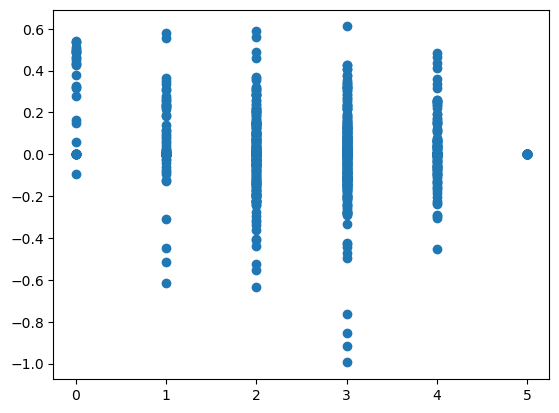

PyObject <matplotlib.collections.PathCollection object at 0x00000000C4A17FA0>

In [45]:
using Graphs

function LatticeToGraph(vertices, edges)
    elist = []
    for edge in edges
        push!(elist, Tuple(edge.∂))
    end
    return SimpleGraph(Graphs.SimpleEdge.(elist));
end




Lvertices, Ledges = LineGraph(vertices, edges) 
LG = LatticeToGraph(Lvertices, Ledges) # line graph (we'll use the graph metric on this)

d = zeros(size(TestK[1,1,:,:]))
for e in eachindex(edges)
    ds = dijkstra_shortest_paths(LG, e)
    d[e,:] .= ds.dists
end

scatter(vec(d), vec(TestK[1,1,:,:]))

In [46]:
contourf(abs.(TestK))

LoadError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\conno\.julia\packages\PyCall\twYvK\src\pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'TypeError'>
TypeError('Input z must be 2D, not 4D')
  File "C:\Users\conno\.julia\conda\3\lib\site-packages\matplotlib\pyplot.py", line 2465, in contourf
    __ret = gca().contourf(
  File "C:\Users\conno\.julia\conda\3\lib\site-packages\matplotlib\__init__.py", line 1423, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "C:\Users\conno\.julia\conda\3\lib\site-packages\matplotlib\axes\_axes.py", line 6414, in contourf
    contours = mcontour.QuadContourSet(self, *args, **kwargs)
  File "C:\Users\conno\.julia\conda\3\lib\site-packages\matplotlib\contour.py", line 794, in __init__
    kwargs = self._process_args(*args, **kwargs)
  File "C:\Users\conno\.julia\conda\3\lib\site-packages\matplotlib\contour.py", line 1435, in _process_args
    x, y, z = self._contour_args(args, kwargs)
  File "C:\Users\conno\.julia\conda\3\lib\site-packages\matplotlib\contour.py", line 1470, in _contour_args
    x, y = self._initialize_x_y(z)
  File "C:\Users\conno\.julia\conda\3\lib\site-packages\matplotlib\contour.py", line 1546, in _initialize_x_y
    raise TypeError(f"Input z must be 2D, not {z.ndim}D")


In [47]:
save("data/MicroKubo.jld", "Size", L,
                           "Fields", 𝒽,
                           "num_histories", num_histories,
                           "therm_runtime", therm_runtime,
                           "runtime", runtime,
                           "t_therm", t_therm,
                           "t_cutoff", t_cutoff,
                           "basis", Basis,
                           "lambda", λ,
                           "xi", ξ,
                           "EnergyQuantisation", δE,
                           "Dself", Dself,
                           "twoFlip", twoFlip,
                           "allComponents", allComponents,
                           "Temperature", T,
                           "Magnetisation", M,
                           "Percolation", ℙ,
                           "Conductivity", κ,
                           "ConductivityStd", κStd,
                           "Capacity", C,
                           "CapacityStd", CStd,
                           "Diffusivity", Diff,
                           "DiffusivityStd", DiffStd)

LoadError: UndefVarError: Dself not defined

In [48]:
κ       = Nothing
C       = Nothing
Diff    = Nothing
M       = Nothing
ℙ       = Nothing
κStd    = Nothing
CStd    = Nothing
DiffStd = Nothing
MStd    = Nothing
ℙStd    = Nothing

Nothing

In [49]:
t3 = now()
print("\n", canonicalize(t3 - t2))


12 seconds, 596 milliseconds

### Diffusive Motion

In [50]:
@everywhere include(dir * "/functions/simulationFunctions/MicroDiffusion.jl")

In [51]:
L = [16, 16]
PBC = [true, true]

therm_runtime = floor(Int64,(maximum(L)./2)^2/2/length(L)/Dself) # 500
runtime = 300
tau = 2:200
num_histories = 5
𝒽 = [0.0] #range(0, 1, length=7)

T = []; # collect(range(0.01, 10.0, length=50));
ℓ = [1];


x, δ, Mag, Perc, p, Nv = DiffSim(L, PBC, Basis, therm_runtime, runtime, ℓ, T, 𝒽);
D, α, C, γ, MSD, VACF = DiffAnalysis(x, δ, p, runtime, ℓ, T, 𝒽);

LoadError: UndefVarError: Dself not defined

In [52]:
figure()
for h in 1:length(x[1][1])
    for p in 1:size(x[1][1][h], 2)
        plot(x[1][1][h][1,p,:], x[1][1][h][2,p,:])
    end
end
savefig("figs/trajectories.pdf")

LoadError: UndefVarError: x not defined

In [53]:
colors = jetmap(length(𝒽))

1-element Vector{Tuple{Float64, Float64, Float64}}:
 (0.0, 0.0, 0.498)

In [54]:
Mag = mean(Mag, dims=3)

figure()
for i in eachindex(𝒽)
    if length(T) > 0
        scatter(T, Mag[:,i], color=colors[i])
        plot(T, Magnetisation(T, 𝒽[i], z), color=colors[i])
    elseif length(ℓ) > 0
        scatter(ℓ, Mag[:,i], color=colors[i])
    end
end
savefig("figs/Magnetisation.png")

LoadError: UndefVarError: Mag not defined

In [55]:
Perc = mean(Perc, dims=3)

figure()
for i in eachindex(𝒽)
    if length(T) > 0
        scatter(T, Perc[:,i], color=colors[i])
    elseif length(ℓ) > 0
        scatter(ℓ, Perc[:,i], color=colors[i])
    end
end

savefig("figs/Percolation.png")

LoadError: UndefVarError: Perc not defined

In [56]:
figure()
for t in 1:size(MSD, 2)
    for i in 1:size(MSD, 3)
        if MSD[tau,t,i] != [NaN for _ in 1:size(MSD, 1)]
            #loglog(MSD[:,t,i], color=colors[i])
            plot(MSD[tau,t,i], color=colors[i])
        end
    end
end
plot(2 .* length(L) .* D[1] .* tau .^ α[1], color=:black, "--")
savefig("figs/MSD.png")

LoadError: UndefVarError: MSD not defined

In [57]:
# step direction autocorrelation
figure()
for t in 1:size(VACF, 2)
    for i in 1:size(VACF, 3)
        if VACF[tau,t,i] != [NaN for _ in 1:size(VACF, 1)]
            #loglog(abs.(VACF[:,t,i]), color=colors[i])
            plot(VACF[tau,t,i], color=colors[i])
        end
    end
end
sgn = sign(VACF[findmax(abs.(VACF[:,1,1]))[2],1,1])
plot(-sgn .* length(L) .* abs(C[1]) .* tau .^ γ[1], color=:black, "--")
savefig("figs/VACF.png")

LoadError: UndefVarError: VACF not defined

In [58]:
# estimate based on assuming the number of particles is <ϵ_i>/2λ/2 in single vertex approxn
figure() # density of quasiparticles
p = mean(p, dims=3) ./ Nv
if length(T) > 0
    for i in eachindex(𝒽)
        scatter(T, p[:,i], color=colors[i])
        plot(T, ExcitationDensity(T, 𝒽[i], z), color=colors[i])
    end
elseif length(ℓ) > 0
    pExp = 2 .* ℓ ./ Nv
    for i in eachindex(𝒽)
        scatter(ℓ, p[:,i], color=colors[i])
    end
    plot(ℓ, pExp, color=:black, "--")
end
savefig("figs/Quasiparticle Number.png")

LoadError: UndefVarError: p not defined

In [59]:
figure() # msd diffusion coefficient
if length(T) > 0
    for i in eachindex(𝒽)
        plot(T[2:end], 2 .* length(L) .* Dfun(T[2:end], 𝒽[i]), color=colors[i])
        
        plotWithError(D[1,:,i], T, colors[i], ".", "" , D[2,:,i])
    end
elseif length(ℓ) > 0
    plot(ℓ, Dself .* (1 .- 2 .* ℓ ./ Nv), color=:black)
    for i in eachindex(𝒽)
        plotWithError(D[1,:,i], ℓ, colors[i], ".", "" , D[2,:,i])
    end
end
savefig("figs/MSD_Coefficient.png")

LoadError: UndefVarError: Dself not defined

In [60]:
figure() # msd diffusion exponent
if length(T) > 1
    for i in eachindex(𝒽)
        plotWithError(α[1,:,i], T, colors[i], ".", "" , α[2,:,i])
    end
elseif length(ℓ) > 0
    for i in eachindex(𝒽)
        plotWithError(α[1,:,i], ℓ, colors[i], ".", "" , α[2,:,i])
    end
end
savefig("figs/MSD_Exponent.png")

LoadError: UndefVarError: ℓ not defined

In [61]:
figure() # vacf diffusion coefficient
if length(T) > 0
    for i in eachindex(𝒽)
        plot(T[2:end], length(L) .* Dfun(T[2:end], 𝒽[i]), color=colors[i])
        
        plotWithError(C[1,:,i], T, colors[i], ".", "" , D[2,:,i])
    end
elseif length(ℓ) > 0
    plot(ℓ, Dself .* (1 .- 2 .* ℓ ./ Nv), color=:black)
    for i in eachindex(𝒽)
        plotWithError(C[1,:,i], ℓ, colors[i], ".", "" , D[2,:,i])
    end
end
savefig("figs/VACF_Coefficient.png")

LoadError: UndefVarError: Dself not defined

In [62]:
figure() # vacf diffusion exponent
if length(T) > 1
    for i in eachindex(𝒽)
        plotWithError(γ[1,:,i], T, colors[i], ".", "" , α[2,:,i])
    end
elseif length(ℓ) > 0
    for i in eachindex(𝒽)
        plotWithError(γ[1,:,i], ℓ, colors[i], ".", "" , α[2,:,i])
    end
end
savefig("figs/VACF_Exponent.png")

LoadError: UndefVarError: ℓ not defined

In [63]:
print("D = ", D[1,1,1], " ± ", D[2,1,1], "\n\n")
print("α = ", α[1,1,1], " ± ", α[2,1,1], "\n\n")
print("C = ", C[1,1,1], " ± ", C[2,1,1], "\n\n")
print("γ = ", γ[1,1,1], " ± ", γ[2,1,1], "\n\n")

LoadError: UndefVarError: D not defined

In [64]:
print(α[1,1,1]+1, " ± ", α[2,1,1], "\n\n")
print(2*γ[1,1,1]+4, " ± ", 2*γ[2,1,1], "\n\n")

LoadError: UndefVarError: α not defined

In [65]:
save("data/MicroDiff.jld", "Size", L,
                           "Fields", 𝒽,
                           "num_histories", num_histories,
                           "therm_runtime", therm_runtime,
                           "runtime", runtime,
                           "tau", tau,
                           "basis", Basis,
                           "lambda", λ,
                           "xi", ξ,
                           "EnergyQuantisation", δE,
                           "Dself", Dself,
                           "twoFlip", twoFlip,
                           "Temperature", T,
                           "NumFlippedEdges", ℓ,
                           "MSD", MSD,
                           "VACF", VACF,
                           "D", D,
                           "alpha", α,
                           "C", C,
                           "gamma", γ)

LoadError: UndefVarError: tau not defined

In [66]:
t4 = now()
print("\n", canonicalize(t4 - t3))


362 milliseconds

### Diffusion Subgraphs

In [1]:
Basis = HexBasis()
L = [16, 16]
PBC = [true, true]

therm_runtime = 1000
T_therm = 0.1
𝒽 = [0.0]
randomInit = false

cells, scale = LatticeGrid(L, PBC, Basis)

_ = MicroKuboSetup(cells, therm_runtime, T_therm, 𝒽, randomInit)

LoadError: UndefVarError: HexBasis not defined

In [ ]:
# find all the excitations
js = []
for j in eachindex(cells[1])
    Aj = A(cells[2], cells[1][j])
    Qj = abs(Q(cells[2], cells[1][j]))

    if (isSpinIce ? (Qj == 3 || Qj == 2) : Aj == -1)
        push!(js, j)
    end
end

In [ ]:
using Graphs

function LatticeToDigraph(vertices, edges)
    elist = []
    for edge in edges
        verts = edge.σ 
        push!(elist, Tuple(edge.∂))
    end
    return SimpleGraph(Graphs.SimpleEdge.(elist));
end

In [ ]:
for j in js # for each excitation, the reachable subgraph
    
end

In [ ]:
t5 = now()
print("\n", canonicalize(t5 - t4))

In [67]:
print("\nTOTAL RUNTIME = ", canonicalize(t5 - t0))


TOTAL RUNTIME = 21 seconds, 109 milliseconds

In [68]:
close("all") 